<a href="https://colab.research.google.com/github/roywaswa/pattern_analysis_us/blob/main/pattern_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POINT PATTERN ANALYSIS OF THE SPREAD OF COVID-19 IN UNITED STATES OF AMERICA (USA) 2020-2022

## INTRODUCTION
The CORONA VIRUS 2019 (referred to as C-19 from hereon out) was contact transmitted virus that ravaged the world from the close of 2019 to the later dates of 2022. One of the most hit countries was the USA with close to 1.2 million casualties.
The aim of this analysis is to attempt to find the spatial relationships between the cases reported in the pandemic and the spread of the pandemic.

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os

## EXPOLRATORY DATA ANALYSIS

### _Data_
Since USA is a very big country with over 1000 counties. The data here is reduced to mainland US. This is to facilitate the spatial correlation and mitigate any disjoint errors due to lack of spatial continuity. Alternatively, This allows for the maps to be compact, as US territory spans from Alaska, to Virgin Islands.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
us_covid_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
us_covid_df = pd.read_csv(us_covid_link)
us_states_gdf = gpd.read_file("https://raw.githubusercontent.com/roywaswa/pattern_analysis_us/main/data/US_State_Boundaries/US_State_Boundaries.shp")
us_counties_gdf = gpd.read_file("/content/drive/My Drive/Colab Notebooks/Data/USA_Counties-wgs84.shp")

# Remove data whose LAT and LONG are not within the US
us_covid_df = us_covid_df[us_covid_df.Lat.between(24, 50) & us_covid_df.Long_.between(-125, -66)]
# Filter the counties states by the state_names
us_counties_gdf = us_counties_gdf[us_counties_gdf.STATE_NAME.isin(us_covid_df.Province_State)]
us_covid_df = us_covid_df.drop(columns=["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Country_Region", "Combined_Key"])
all_dates = list(us_covid_df.columns[4:])

In [5]:
# Select first date of each month
first_dates = [date for date in all_dates if date.split("/")[1] == "1"]
us_covid_df = us_covid_df[["Province_State", "Lat", "Long_","Population", *first_dates]]

# Filter by mainland US states
state_names = list(us_states_gdf['NAME'])
us_covid_df = us_covid_df[us_covid_df['Province_State'].isin(state_names)]

# Generate new geodataframe with covid data from lat and long
us_covid_gdf = gpd.GeoDataFrame(us_covid_df, geometry=gpd.points_from_xy(us_covid_df.Long_, us_covid_df.Lat))
us_covid_gdf.crs = us_states_gdf.crs

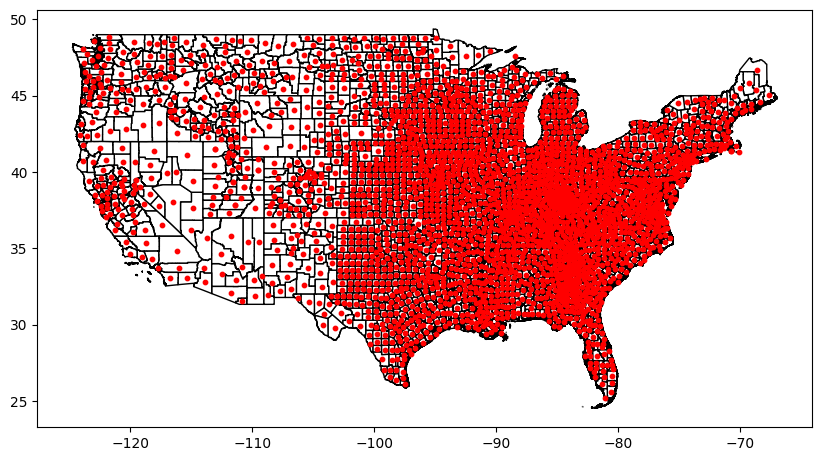

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
us_counties_gdf.plot(ax=ax, color='white', edgecolor='black')
us_covid_gdf.plot(ax=ax, color='red', markersize=10)
fig.show()

<Axes: >

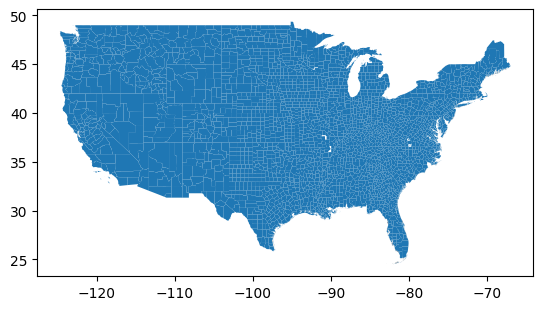

In [8]:
# Merge the two geodataframes based on intersection
us_covid_counties_gdf = gpd.sjoin( us_counties_gdf,us_covid_gdf, how='inner', predicate='intersects')
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
us_covid_counties_gdf.plot()



### Exploratory Date

The date of September 1st 2020 will be taken for the sake of exploratory analysis of spatial metrics. This will later be expanded iteratively to all the months between 2020 - 2022 (24 months)

In [9]:
all_columns = list(us_covid_counties_gdf.columns)
rel_columns = all_columns[:all_columns.index("Population")+1]
rel_columns.append(all_columns[all_columns.index("9/1/20")])

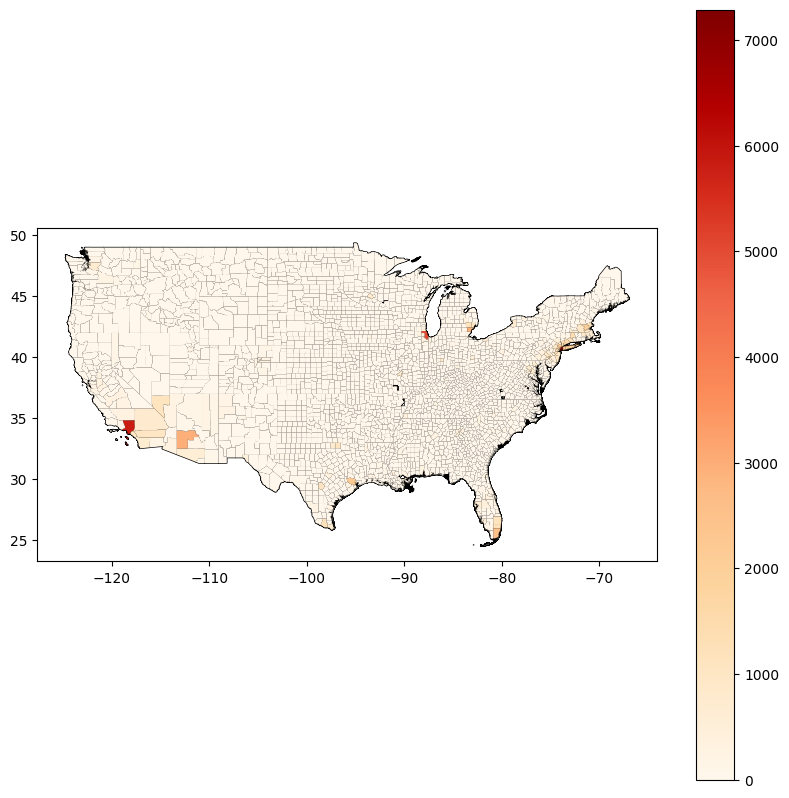

In [10]:
us_cc_sep = us_covid_counties_gdf[rel_columns]
# Plot choropleth map of the deaths on 9/1/20
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
us_counties_gdf.plot(ax=ax, color='white', edgecolor='black')
us_cc_sep.plot(column="9/1/20", ax=ax, legend=True, cmap="OrRd")
fig.show()


In [27]:
!pip install -q pysal libpysal legendgram esda

In [16]:
import libpysal as psl
import pysal as ps
import esda
from legendgram import legendgram

In [17]:
weights =psl.weights.Queen.from_dataframe(us_cc_sep)
morans = esda.Moran(us_cc_sep["9/1/20"], weights)

<ipython-input-17-ce468426014c>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights =psl.weights.Queen.from_dataframe(us_cc_sep)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


In [21]:
lisa = esda.Moran_Local(us_covid_counties_gdf["6/1/20"], weights)
# Explore lisa.Is (local Moran's I values) and lisa.q (quadrants)

In [26]:
print(f"Moran's I: {morans.I:.3f}")
print(f"p-value: {morans.p_sim:.3f}")

Moran's I: 0.540
p-value: 0.001
